## Create A Network Grid from Raster Grid

This notebook takes an .asc raster file representing a DEM and extracts a channel network from the topography using the [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html). It then uses this extracted channel network to create a NetworkModelGrid.

In [47]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

## Import a DEM
Setup this notebook to draw DEM data for the Hugo Site from the overland_flow tutorial folder.

In [2]:
tutorial_dir = os.path.dirname(os.getcwd())
raster_fn = os.path.join(tutorial_dir, 'overland_flow\\hugo_site.asc')

Import the Hugo Site as a RasterModelGrid and visualize:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


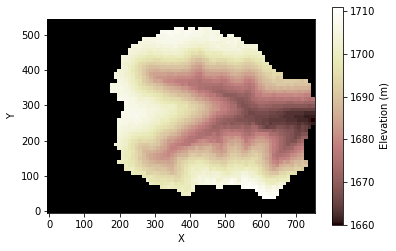

In [3]:
rmg, z = read_esri_ascii(raster_fn, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED


plt.figure()
imshow_grid_at_node(rmg, z, colorbar_label='Elevation (m)')
plt.show()

## Find flow accumulation:

Find where water will flow using the FlowAccumulator package:

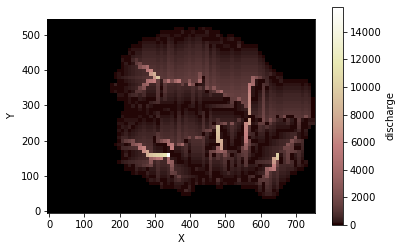

In [4]:
fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

Yuck, that doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

In [5]:
df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

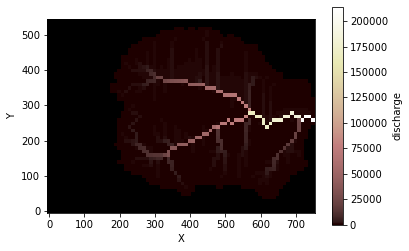

In [6]:
imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

That looks better! 

## Use the channel profiler to extract channels:
* note, toggle minimum channel threshhold to refine network!

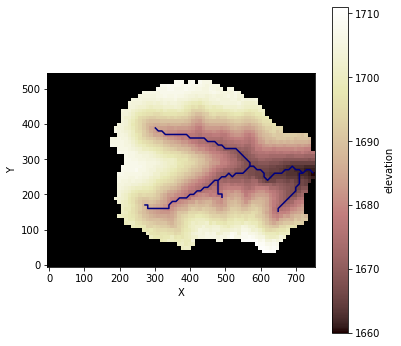

In [7]:
min_channel_thresh = 10000

profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=min_channel_thresh,
    main_channel_only=False,
    cmap='jet',
)
profiler.run_one_step()

plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')

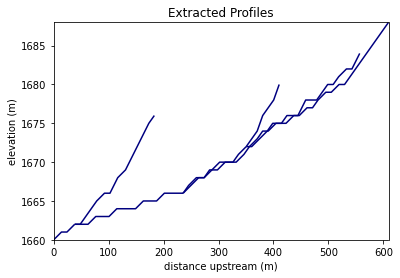

In [8]:
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

## Get network-grid nodes from channel.

Extract x,y network model grid (nmg) nodes from raster model grid (rmg) for each deliniated channel segment:
* note: need to remove duplicate values from channel junctures and create node_at_link list (more notes below)

In [62]:
d_node_spacing = 25 #units to space nodes, must be greater than grid resolution
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each channel segment
nodes_per_segment = [] #empty list to store number of nodes in each channel segment

#DEV ONLY: keep track of nodes per seg as explicit x and y locations (only toggle if using below)
# x_of_nodes = []
# y_of_nodes = []

#would be ideal to also create dictionary here that stores rmg cells along each link to tie rmg properties to nmg
#nmg_cells_on_link = {}

#obtain watershed key
ws_keys = [k for k in profiler.data_structure.keys()]

#sent message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('more than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    
    #access individual segment
    seg_i = profiler.data_structure[2051][seg_key] 
    
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    nodes_per_segment.append(n_possible_nodes)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #DEV ONLY: keep track of nodes per seg as explicit x and y locations
#     x_of_nodes.append(rmg.x_of_node[rmg_nodes_i])
#     y_of_nodes.append(rmg.y_of_node[rmg_nodes_i])
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

#get unique nodes
xy_df = pd.DataFrame({'x': x_of_nodes, 'y': y_of_nodes})
uniq_x_of_nodes = xy_df.drop_duplicates()['x'].values
uniq_y_of_nodes = xy_df.drop_duplicates()['y'].values

Plot nodes colored by segment:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


Text(0.5, 1.0, 'Network Nodes colored by channel segment')

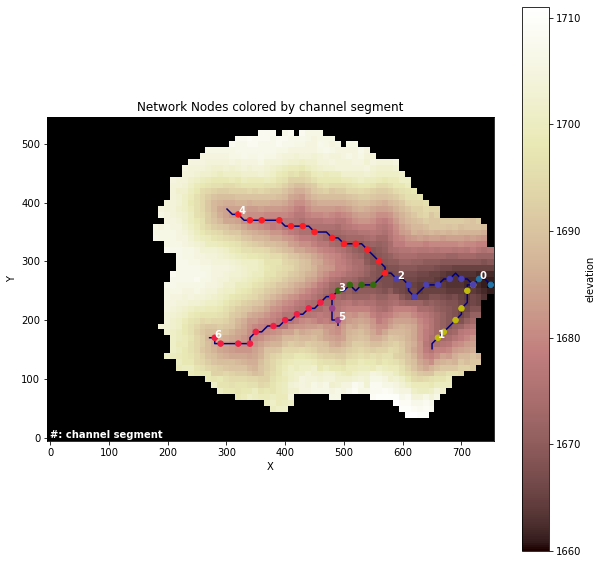

In [90]:
plt.figure(figsize = (10,10))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)

#hacky way to label channel segments with #s -------
node_id = 0 #dummy counter
idx_x = [] #store indexes to acces x,y location of last node on channel
#loop through channels, get node index
for node_len in nodes_per_segment:
    node_id+=node_len
    idx_x.append(node_id-1)
#plot numbers at last node for each channel seg
for i in range(n_channel_segs):
    plt.text(x_of_nodes[idx_x[i]],
             y_of_nodes[idx_x[i]],
             '%d'%i,
             color='white',
             fontweight='bold')
plt.text(0,0,
         '#: channel segment',
         color='white',
         fontweight='bold')
#---------------------------------------------------
plt.title('Network Nodes colored by channel segment')

Text(0.5, 1.0, 'Network Nodes')

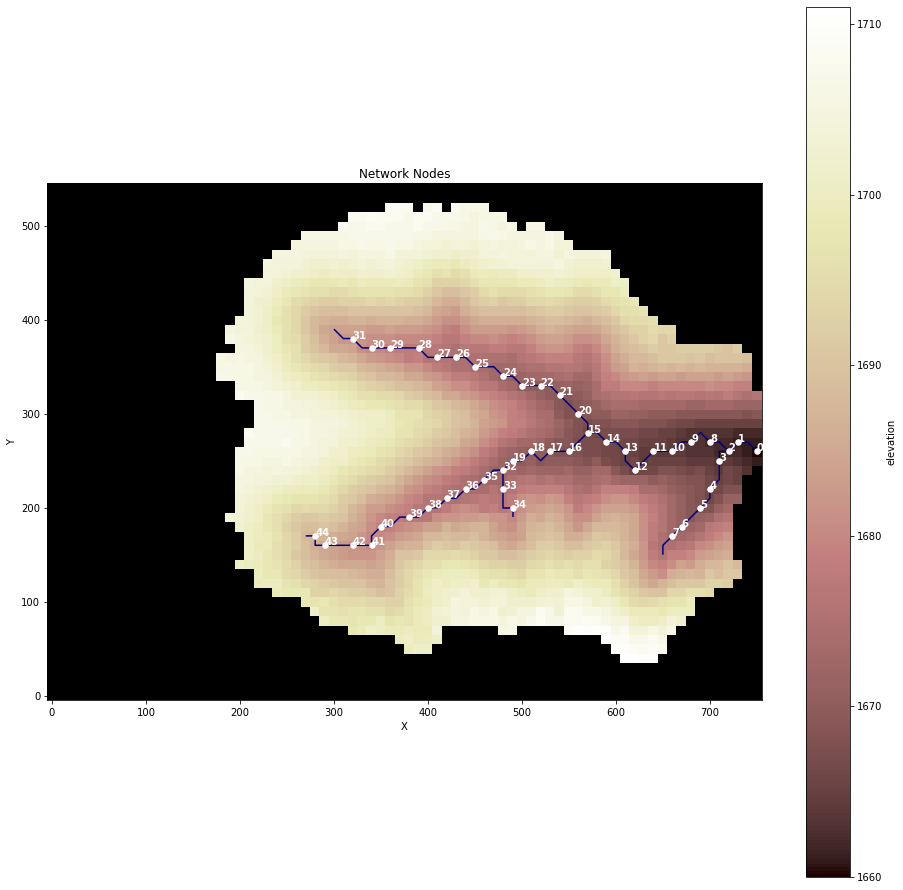

In [65]:
plt.figure(figsize = (16,16))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(uniq_x_of_nodes, uniq_y_of_nodes, s=30, c='white', zorder=2)
for i, (x,y) in enumerate(zip(uniq_x_of_nodes, uniq_y_of_nodes)):
    plt.text(x,y,
            '%d'%i,
             color='white',
            fontweight='bold')
#---------------------------------------------------
plt.title('Network Nodes')

#### Figure out how to get 'node at link' value for nmg:
* this is a work-in-progress... 

NEED TO:
* distinguish between outlet, channel head, or juncture at start and end of each segment
    * if outlet: 
        * create node at beginning
        * attach to upstream nodes
    * if juncture: 
        * create node at beginning (ONLY if a node hasn't already been created from another juncture) 
        * also tell the previous segment that it needs to be attached to this node idx (ONLY if it hasn't been attached from previous juncture)
    * if channel head: 
        * end with upstream node--don't attach to any other nodes
        * reduce idx of subsequent link numbers by 1 (since there is no link for this node)

In [82]:
#extract array of start and end nodes
profile_start_and_end_nodes = np.array([[n1, n2] for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])
channel_start_nodes = np.array([n1 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])
channel_end_nodes = np.array([n2 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])

#create dictionary that holds segment endpoint type
#(this simply prints out a check to make sure things are being joined properly)
segment_endpoint_type = OrderedDict()

#define empty list to hold nodes per link
nodes_at_link_per_seg = OrderedDict()

#find idx of link per segment
idx_link_per_segment = np.cumsum(nodes_per_segment)-1
idx_node_per_segment = np.cumsum(nodes_per_segment)

#iterate through channel segments to determine where to join
for i, key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    
    #analyze first segment
    if i==0:
        #first endpoint: should be outlet
        segment_endpoint_type[i] = ['outlet: create node']
        #loop through all nodes in each segment and create link references for nmg
        nodes_at_link_per_seg[i] = [(n+1, n) for n in range(idx_link_per_segment[i])]
        
        #second endpoint:
        #check if end of segment equals start of any other segments
        if np.any(channel_start_nodes == channel_end_nodes[i]):
            #extract index of the first place this is true (first juncture where the node will have been created)
            first_juncture_idx = np.where(channel_start_nodes == channel_end_nodes[i])[0][0]
            segment_endpoint_type[i].append('juncture: join to first node of seg %d'%(first_juncture_idx))
            
            #add a link to nmg at end of segment, linking the first node in the next segment to end of this segment
            #do this by finding the first juncture, going to the length of the segment right before it and adding a node
            nodes_at_link_per_seg[i].insert(idx_link_per_segment[i],
                                            ((idx_link_per_segment[first_juncture_idx-1]+1), idx_link_per_segment[i]))
        
        else:
            segment_endpoint_type[i].append('channel head: dont join')
    
    #analyze rest of segments
    if i > 0:
        #first endpoint:
        #check if first point equals start of any previous start points (means it's a SECOND JUNCTURE instance)
        if np.any(channel_start_nodes[:i] == channel_start_nodes[i]): 
            #extract the first index of these
            first_juncture_idx = np.where(channel_start_nodes[:i] == channel_start_nodes[i])[0][0] 
            segment_endpoint_type[i] = ['2nd juncture: refer to first node of seg %d'%(first_juncture_idx)]
            
            #create link reference for this segment
            #loop through (n+1:n-1) links in each segment and create link references for nmg
            nodes_at_link_per_seg[i] = [(n+1, n) for n in range((idx_link_per_segment[i-1]+1), idx_link_per_segment[i]-1)]
            #insert link reference at beginning according to previously created node
            nodes_at_link_per_seg[i].insert(0, (idx_link_per_segment[i-1]+1, idx_link_per_segment[first_juncture_idx-1]+1))
        
        #FIRST JUNCTURE instance
        else:
            segment_endpoint_type[i] = ['1st juncture: create node']
            #check here if indexing works to make list starting with current idx of if need to jump back
            
            #loop through all nodes in each segment and create link references for nmg
            nodes_at_link_per_seg[i] = [(n+1, n) for n in range((idx_link_per_segment[i-1]+1), idx_link_per_segment[i])]

            
        #second endpoint: check if end of segment equals start of future segments
        #SECOND JUNCTURES
        if np.any(profile_start_and_end_nodes[:,0] == profile_start_and_end_nodes[i, 1]):
            first_juncture_idx = np.where(profile_start_and_end_nodes[:,0]==profile_start_and_end_nodes[i, 1])[0][0]
            segment_endpoint_type[i].append('juncture: join to first node of seg %d'%(first_juncture_idx))
            
        #CHANNEL HEADS
        else:
            segment_endpoint_type[i].append('channel head: dont join')
            idx_link_per_segment[i+1:] -= 1 
            

    print('segment %d:'%i, segment_endpoint_type[i])

segment 0: ['outlet: create node', 'juncture: join to first node of seg 1']
segment 1: ['1st juncture: create node', 'channel head: dont join']
segment 2: ['2nd juncture: refer to first node of seg 1', 'juncture: join to first node of seg 3']
segment 3: ['1st juncture: create node', 'juncture: join to first node of seg 5']
segment 4: ['2nd juncture: refer to first node of seg 3', 'channel head: dont join']
segment 5: ['1st juncture: create node', 'channel head: dont join']
segment 6: ['2nd juncture: refer to first node of seg 5', 'channel head: dont join']


In [88]:
for i, key in enumerate(nodes_at_link_per_seg.keys()):
    print('segment %d nodes at link:'%i, nodes_at_link_per_seg[key])

segment 0 nodes at link: [(1, 0), (2, 1)]
segment 1 nodes at link: [(3, 2), (4, 3), (5, 4), (6, 5), (7, 6)]
segment 2 nodes at link: [(8, 2), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12)]
segment 3 nodes at link: [(16, 15), (17, 16), (18, 17), (19, 18)]
segment 4 nodes at link: [(20, 15), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30)]
segment 5 nodes at link: [(34, 33)]
segment 6 nodes at link: [(35, 33), (36, 35), (37, 36), (38, 37), (39, 38), (40, 39), (41, 40), (42, 41), (43, 42)]


Still not quite assigning things properly at junctures for end of segment 2 and above: